# Image Classification

## Get the Data

In [83]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


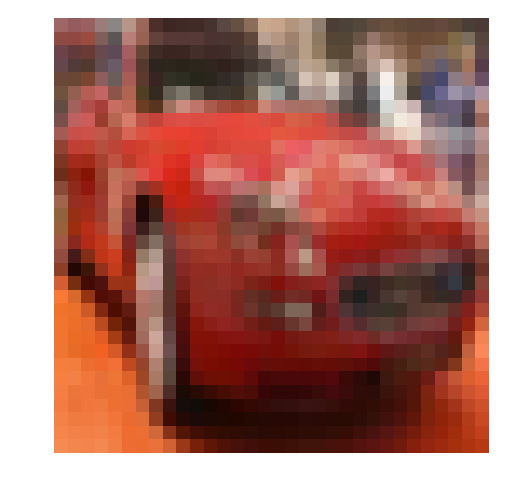

In [84]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize

In [85]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x_max = np.max(x)
    x_min = np.min(x)
    return (x - x_min) / (x_max - x_min)

tests.test_normalize(normalize)

Tests Passed


### One-hot encode

In [86]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    x_one_hot = np.zeros((len(x), 10))
    for i in range(len(x)):
        x_one_hot[i, x[i]] = 1
    return x_one_hot

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it

In [87]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point

In [88]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

In [89]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, [None, *image_shape], name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, [None, n_classes], name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name='keep_prob')


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer

In [90]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight = tf.Variable(tf.truncated_normal([*conv_ksize, x_tensor.get_shape().as_list()[3], conv_num_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    x = tf.nn.conv2d(x_tensor,
                     weight,
                     [1, *conv_strides, 1],
                     padding='SAME')
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x,
                       [1, *pool_ksize, 1],\
                       [1, *pool_strides, 1],
                       padding='SAME')
    return x


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer

In [91]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    x_shape = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [-1, x_shape[1]*x_shape[2]*x_shape[3]])


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer

In [124]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_tensor_shape = x_tensor.get_shape().as_list()
    print(x_tensor_shape)
    fully_weight = tf.Variable(tf.truncated_normal([x_tensor_shape[1], num_outputs], stddev=0.1))
    fully_bias = tf.Variable(tf.zeros(num_outputs))
    x = tf.add(tf.matmul(x_tensor, fully_weight), fully_bias)
    
    return tf.nn.relu(x)

tests.test_fully_conn(fully_conn)

[None, 128]
Tests Passed


### Output Layer

In [125]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_tensor_shape = x_tensor.get_shape().as_list()
    output_weight = tf.Variable(tf.truncated_normal([x_tensor_shape[1], num_outputs], stddev=0.1))
    output_bias = tf.Variable(tf.zeros(num_outputs))
    return tf.add(tf.matmul(x_tensor, output_weight), output_bias)


tests.test_output(output)

Tests Passed


### Create Convolutional Model

In [126]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Apply 1, 2, or 3 Convolution and Max Pool layers
    x = conv2d_maxpool(x, 32, (3, 3), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 64, (3, 3), (2, 2), (3, 3), (2, 2))

    # Apply a Flatten Layer
    x = flatten(x)
    

    # Apply 1, 2, or 3 Fully Connected Layers
    x = fully_conn(x, 1024)
    x = tf.nn.dropout(x, keep_prob = keep_prob)
    
    # Apply an Output Layer
    x = output(x, 10)
    
    
    # return output
    return x


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
# optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

[None, 1024]
[None, 1024]
Neural Network Built!


## Train the Neural Network

In [127]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer,
                feed_dict={x:feature_batch,
                           y:label_batch,
                           keep_prob:keep_probability})


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats

In [128]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x:feature_batch,
                                 y:label_batch,
                                 keep_prob:1.0})
    valid_acc = session.run(accuracy, feed_dict={x:valid_features,
                                     y:valid_labels,
                                     keep_prob:1.0})
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                loss,
                valid_acc))

### Hyperparameters

In [132]:
epochs = 20
batch_size = 128
keep_probability = 0.75

### Train on a Single CIFAR-10 Batch

In [133]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.6928 Validation Accuracy: 0.404600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3515 Validation Accuracy: 0.489000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.1290 Validation Accuracy: 0.505200
Epoch  4, CIFAR-10 Batch 1:  Loss:     0.9835 Validation Accuracy: 0.530400
Epoch  5, CIFAR-10 Batch 1:  Loss:     0.8781 Validation Accuracy: 0.560600
Epoch  6, CIFAR-10 Batch 1:  Loss:     0.7951 Validation Accuracy: 0.566400
Epoch  7, CIFAR-10 Batch 1:  Loss:     0.6602 Validation Accuracy: 0.571600
Epoch  8, CIFAR-10 Batch 1:  Loss:     0.5119 Validation Accuracy: 0.583000
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.4410 Validation Accuracy: 0.581200
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.3766 Validation Accuracy: 0.578800
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.2832 Validation Accuracy: 0.594400
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.2838 Validation Accuracy: 0.579200
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.2136

### Fully Train the Model

In [134]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.7982 Validation Accuracy: 0.389000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.3835 Validation Accuracy: 0.476000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.2158 Validation Accuracy: 0.504800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.1125 Validation Accuracy: 0.547600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.1173 Validation Accuracy: 0.562200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.2469 Validation Accuracy: 0.556400
Epoch  2, CIFAR-10 Batch 2:  Loss:     0.9080 Validation Accuracy: 0.590600
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.8871 Validation Accuracy: 0.596000
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.8263 Validation Accuracy: 0.616600
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8878 Validation Accuracy: 0.615400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.0776 Validation Accuracy: 0.610800
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.7475 Validation Accuracy: 0.632400
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.7072 Validation Accuracy: 0.631600


# Checkpoint
## Test Model

Testing Accuracy: 0.7073773734177216



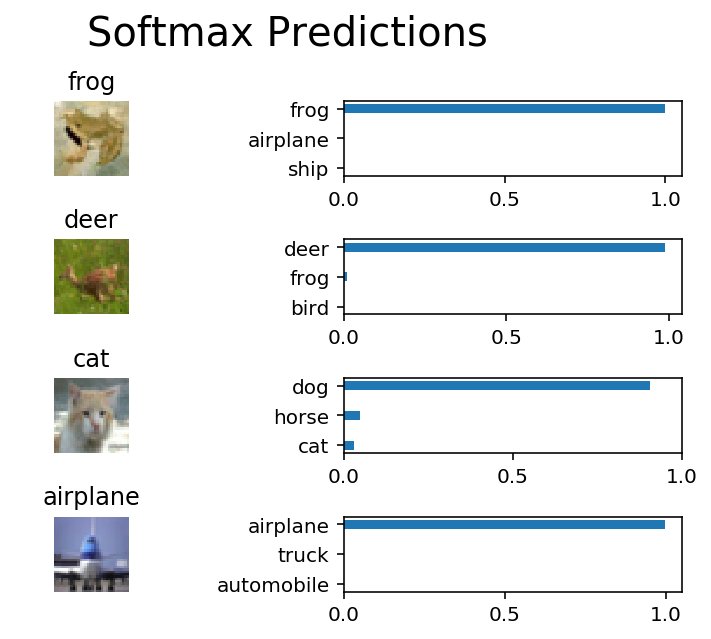

In [135]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()